In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime, timedelta
from fastai.tabular import add_datepart
from scipy.stats import ks_2samp

# Loading datasets, feature engineering

In [2]:
print('These are the datasets available: \n', os.listdir('flow data/flow data'))
#Note: the usgs_data.csv is just the table from usgs_san_francisquito.txt

These are the datasets available: 
 ['usgs_san_francisquito.txt', 'usgs_data.csv', 'influent_flow.csv', 'weather.csv']


## Flow data

In [3]:
#Looking at influent_flow.csv table, the table containing our target
flow = pd.read_csv('flow data/flow data/influent_flow.csv')

#Change the date column to a datetime type
flow['Date'] = pd.to_datetime(flow['Date'])

print(flow.info())
flow.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34516 entries, 0 to 34515
Data columns (total 2 columns):
Date        34516 non-null datetime64[ns]
INF_FLOW    34516 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 539.4 KB
None


,Date,INF_FLOW
0,2013-01-15 00:00:00,9.589273
1,2013-01-15 01:00:00,9.272833
2,2013-01-15 02:00:00,8.861329
3,2013-01-15 03:00:00,9.193454
4,2013-01-15 04:00:00,9.129482


## Weather Data

In [4]:
#Looking at weather table
weather = pd.read_csv('flow data/flow data/weather.csv')

#Change the date column to a datetime type
weather['Date'] = pd.to_datetime(weather['Date'])

print(weather.info())
weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44784 entries, 0 to 44783
Data columns (total 8 columns):
Date               44784 non-null datetime64[ns]
rain               44784 non-null float64
snow               44784 non-null float64
accum              44784 non-null float64
temp               44784 non-null float64
humidity           44784 non-null float64
cloud              44784 non-null float64
app_temperature    44784 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 2.7 MB
None


,Date,rain,snow,accum,temp,humidity,cloud,app_temperature
0,2012-12-15 08:00:00,0.0,0.0,0.0,5.95,0.89,0.08,5.95
1,2012-12-15 09:00:00,0.0,0.0,0.0,5.66,0.92,0.09,5.66
2,2012-12-15 10:00:00,0.0,0.0,0.0,5.46,0.91,0.09,5.46
3,2012-12-15 11:00:00,0.0,0.0,0.0,4.82,0.92,0.06,4.82
4,2012-12-15 12:00:00,0.0,0.0,0.0,4.61,0.93,0.03,4.61


## USGS Data

In [5]:
#Looking at usgs_san_francisuito.txt table
usgs = pd.read_csv('flow data/flow data/usgs_data.csv', sep = '\t', low_memory = False)
 #Looks like we have some missing values in the last 4 columns

#get rid of row 0 (indicating datatype and length for each column)
usgs.drop(0, inplace= True)

#Change the date column to a datetime for this table as well
usgs['datetime'] = pd.to_datetime(usgs['datetime'])

#The original usgs text file indicates the 14747_00060 and 14748_0065 columns 
#indicate discharge and gage height. Lets change the name of those columns
#and their corresponding qualification codes. Let's also rename the 'datetime'
#to 'Date' to be consitent with the other tables

usgs.rename(columns = {'14747_00060': 'discharge', 
            '14747_00060_cd': 'discharge_cd',
            '14748_00065' : 'gage_height',
            '14748_00065_cd' : 'gage_height_cd',
            'datetime' : 'Date'},
           inplace = True)

#convert discharge and gage_height to numerical values
usgs['discharge'] = usgs['discharge'].astype('float')
usgs['gage_height'] = usgs['gage_height'].astype('float')

print(usgs.info())
usgs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178895 entries, 1 to 178895
Data columns (total 8 columns):
agency_cd         178895 non-null object
site_no           178895 non-null object
Date              178895 non-null datetime64[ns]
tz_cd             178895 non-null object
discharge         178675 non-null float64
discharge_cd      178675 non-null object
gage_height       178760 non-null float64
gage_height_cd    178760 non-null object
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 12.3+ MB
None


,agency_cd,site_no,Date,tz_cd,discharge,discharge_cd,gage_height,gage_height_cd
1,USGS,11164500,2013-01-01 00:00:00,PST,44.1,A,1.27,A
2,USGS,11164500,2013-01-01 00:15:00,PST,44.1,A,1.27,A
3,USGS,11164500,2013-01-01 00:30:00,PST,44.1,A,1.27,A
4,USGS,11164500,2013-01-01 00:45:00,PST,43.2,A,1.26,A
5,USGS,11164500,2013-01-01 01:00:00,PST,43.2,A,1.26,A


#### Comparing approved and non-approved data

/home/lucas/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/lucas/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


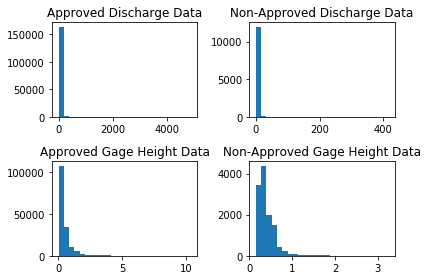

In [6]:
#Comparing approved and non approved data
usgs_A = usgs[(usgs['discharge_cd'] == 'A') &  (usgs['gage_height_cd'] == 'A')]
usgs_not_A = usgs[(usgs['discharge_cd'] != 'A') |  (usgs['gage_height_cd'] != 'A')]


fig, axs = plt.subplots(2, 2)

axs[0,0].hist(usgs_A['discharge'], bins = 25)
axs[0,0].set_title('Approved Discharge Data')

axs[0,1].hist(usgs_not_A['discharge'], bins = 25)
axs[0,1].set_title('Non-Approved Discharge Data')

axs[1,0].hist(usgs_A['gage_height'], bins = 25)
axs[1,0].set_title('Approved Gage Height Data')

axs[1,1].hist(usgs_not_A['gage_height'], bins = 25)
axs[1,1].set_title('Non-Approved Gage Height Data')

plt.tight_layout()

In [7]:
# It's fairly clear by comparing these histograms the distributions (particulary the axis values) of the approved 
# and non-approved data is different. We can test this using the kolmogorov-smirnov test, which tests 
# whether 2 samples come from the same continuous distribution

discharge_distn_test = ks_2samp(usgs_A['discharge'], usgs_not_A['discharge'])
gage_distn_test = ks_2samp(usgs_A['gage_height'], usgs_not_A['gage_height'])

print(discharge_distn_test, gage_distn_test)



Ks_2sampResult(statistic=0.26367390186417167, pvalue=0.0) Ks_2sampResult(statistic=0.25454487280388177, pvalue=0.0)


In [8]:
# For both gage height and discharge, the test is rejected -> distributions are different
# We'll use just approved discharge and gage_height data going forward

usgs = usgs[(usgs['discharge_cd'] == 'A') &  (usgs['gage_height_cd'] == 'A')]

### Merge the data

In [9]:
#Now that the 3 dataframes have been cleaned up a bit lets merge them together by date
df = flow.merge(weather, on = 'Date')
df = df.merge(usgs, on = 'Date')
df.set_index('Date', inplace = True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34268 entries, 2013-01-15 00:00:00 to 2016-12-22 14:00:00
Data columns (total 15 columns):
INF_FLOW           34268 non-null float64
rain               34268 non-null float64
snow               34268 non-null float64
accum              34268 non-null float64
temp               34268 non-null float64
humidity           34268 non-null float64
cloud              34268 non-null float64
app_temperature    34268 non-null float64
agency_cd          34268 non-null object
site_no            34268 non-null object
tz_cd              34268 non-null object
discharge          34268 non-null float64
discharge_cd       34268 non-null object
gage_height        34268 non-null float64
gage_height_cd     34268 non-null object
dtypes: float64(10), object(5)
memory usage: 4.2+ MB
None


In [10]:
#Columns with only one unique value wont have any effect and just take up space
unique_value_cols = [col for col in df.columns if df[col].unique().size == 1]
unique_value = [df[col].unique()[0] for col in df.columns if df[col].unique().size == 1]
print('Column name: \t' ,unique_value_cols,'\nUnique Value\t', unique_value)

Column name: 	 ['snow', 'accum', 'agency_cd', 'site_no', 'discharge_cd', 'gage_height_cd'] 
Unique Value	 [0.0, 0.0, 'USGS', '11164500', 'A', 'A']


In [11]:
#Drop those columns
df.drop(unique_value_cols, axis = 1, inplace = True)
df.head()

,INF_FLOW,rain,temp,humidity,cloud,app_temperature,tz_cd,discharge,gage_height
Date,,,,,,,,,
2013-01-15 00:00:00,9.589273,0.0,10.19,0.26,0.04,10.19,PST,17.1,0.86
2013-01-15 01:00:00,9.272833,0.0,9.76,0.31,0.18,9.76,PST,17.1,0.86
2013-01-15 02:00:00,8.861329,0.0,7.80,0.36,0.07,6.92,PST,17.1,0.86
2013-01-15 03:00:00,9.193454,0.0,6.52,0.43,0.03,6.52,PST,17.1,0.86
2013-01-15 04:00:00,9.129482,0.0,5.69,0.48,0.03,5.69,PST,16.7,0.85


### Daylight Savings

In [12]:
# I noticed the timezone values (PST, PDT) and thought to check for daylight savings time change

df.loc['2013-03-10 00:00:00':'2013-03-10 05:00:00'] #<- to show DST occuring

,INF_FLOW,rain,temp,humidity,cloud,app_temperature,tz_cd,discharge,gage_height
Date,,,,,,,,,
2013-03-10 00:00:00,9.423984,0.0,16.93,0.50,0.04,16.93,PST,6.06,0.59
2013-03-10 01:00:00,9.097989,0.0,17.06,0.52,0.03,17.06,PST,6.06,0.59
2013-03-10 03:00:00,8.230157,0.0,13.42,0.71,0.04,13.42,PDT,5.80,0.58
2013-03-10 04:00:00,7.811428,0.0,11.70,0.72,0.00,11.70,PDT,5.80,0.58
2013-03-10 05:00:00,7.814624,0.0,10.78,0.75,0.00,10.78,PDT,5.80,0.58


In [13]:
#Preserve local dattime in new column incase it's needed later.
local_time =  df.index

In [14]:
#Drop the timezone column
df.drop('tz_cd', axis = 1, inplace = True)

In [15]:
#Convert the datetime index to GMT.
dti = pd.date_range(start = '2013-01-15', freq = 'H', periods = df.shape[0], tz = 'GMT')
df.index = dti
df.index.name = 'Date_GMT'
df.loc['2013-03-10 00:00:00':'2013-03-10 05:00:00']

,INF_FLOW,rain,temp,humidity,cloud,app_temperature,discharge,gage_height
Date_GMT,,,,,,,,
2013-03-10 00:00:00+00:00,9.423984,0.0,16.93,0.50,0.04,16.93,6.06,0.59
2013-03-10 01:00:00+00:00,9.097989,0.0,17.06,0.52,0.03,17.06,6.06,0.59
2013-03-10 02:00:00+00:00,8.230157,0.0,13.42,0.71,0.04,13.42,5.80,0.58
2013-03-10 03:00:00+00:00,7.811428,0.0,11.70,0.72,0.00,11.70,5.80,0.58
2013-03-10 04:00:00+00:00,7.814624,0.0,10.78,0.75,0.00,10.78,5.80,0.58
2013-03-10 05:00:00+00:00,7.510198,0.0,10.69,0.78,0.07,10.69,5.80,0.58


### Creating Time Features

In [16]:
# The prompt mentions the plant doesn't control the amount of flow coming in. This likely means
# the flow is mostly caused by natural cycles. Considering this, datetime units indicating natural 
# cycles (i.e hour of day, time of year) are probably important

df['dt_hour_of_day'] = pd.DatetimeIndex(df.index).hour

#This will add most calendar date features. Dropping dt_Elapsed since it's colinear with other features.
df['dt_'] = df.index
df = add_datepart(df, 'dt_', drop = True).drop('dt_Elapsed', axis = 1)

In [17]:
df.columns

Index(['INF_FLOW', 'rain', 'temp', 'humidity', 'cloud', 'app_temperature',
       'discharge', 'gage_height', 'dt_hour_of_day', 'dt_Year', 'dt_Month',
       'dt_Week', 'dt_Day', 'dt_Dayofweek', 'dt_Dayofyear', 'dt_Is_month_end',
       'dt_Is_month_start', 'dt_Is_quarter_end', 'dt_Is_quarter_start',
       'dt_Is_year_end', 'dt_Is_year_start'],
      dtype='object')

### Exploring Trends

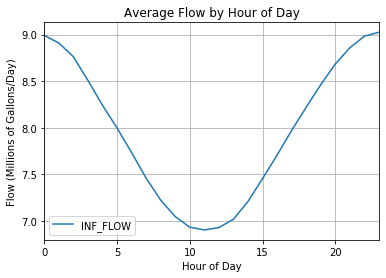

In [18]:
#This is interesting. Flow has an almost perfect cosine shaped trend over the course of an average day

hourly_flow_trend = df.groupby(['dt_hour_of_day'])['INF_FLOW'].mean()
hourly_flow_trend.plot(grid = True)
plt.xlabel('Hour of Day')
plt.title('Average Flow by Hour of Day')
plt.ylabel('Flow (Millions of Gallons/Day)')
plt.legend(labels = ['INF_FLOW'])

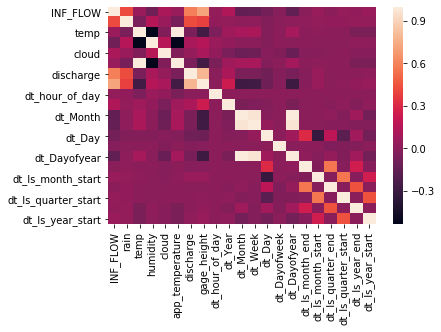

In [19]:
sn.heatmap(df.corr())
plt.show()

In [20]:
df.corr()['INF_FLOW']

INF_FLOW               1.000000
rain                   0.420401
temp                   0.054821
humidity              -0.096054
cloud                  0.111640
app_temperature        0.051046
discharge              0.586279
gage_height            0.723594
dt_hour_of_day         0.028484
dt_Year                0.126488
dt_Month              -0.145092
dt_Week               -0.133550
dt_Day                -0.076513
dt_Dayofweek          -0.015543
dt_Dayofyear          -0.150560
dt_Is_month_end       -0.006333
dt_Is_month_start      0.049138
dt_Is_quarter_end      0.005423
dt_Is_quarter_start    0.034965
dt_Is_year_end         0.026553
dt_Is_year_start       0.055474
Name: INF_FLOW, dtype: float64

Apparent temperature has high correlation with correlation with temperature, as one would expect. Best to drop it in final model to avoid colinerarity. 

Gage height and discharge have the highest correlations with flow. The prompt mentions these are known to be good predictors from past experience


# Model

I decided to use a Random Forest for a few reasons:
   1. Great at handling mixed data types
   2. Highly interpretable. The intuition behind decision trees/random forests is easy to understand (even more 
       than linear regression or especially something like a neural network)
   3. The .feature_importances() attribute makes it almost trivial to determine strongest predictors. The 
       magnitude of model cofficients in linear regression don't necessarily determine strength of prediciton.
   4. Familiarity
       
Due to time constraints, I used Random Search Cross Validation rather than Grid Search for hyperparameter tuning. Given more time, I would use the latter with more parameters options for the absolute best results.

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
import pickle

In [53]:
data = df.drop('app_temperature', axis = 1)
y = data['INF_FLOW']
X = data[data.columns[1:]]
                
#Splitting off some data for validation purposes
X_train, X_val = np.split(X, [int(.75*len(data))])
y_train, y_val = np.split(y, [int(.75*len(data))]) 

In [57]:
#parameter grid for random search. Somewhat few values tried because of time restraints
random_grid = {'n_estimators' : [100,250,500],
       'max_depth' : [10, 50, 100],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_leaf' : [1, 2 ,4],
       'min_samples_split' : [2, 5, 10]}

#base model
rf = RandomForestRegressor(random_state = 17)

#make time series splits for cross validation
tscv = TimeSeriesSplit(n_splits = 5).split(X_train)

rf_random_search = RandomizedSearchCV(estimator = rf, 
                                    param_distributions = random_grid,
                                      n_iter = 10,
                                      cv = tscv,
                                      random_state = 17,
                                      n_jobs = -1,
                                      verbose = 2)


In [58]:
rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.4s
/home/lucas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7ff242ba0de0>,
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_est...
                                                   n_jobs=None, oob_score=False,
 

In [60]:
#Show the best combinations of hyperparamters
results_ranked = pd.DataFrame(rf_random_search.cv_results_).sort_values(by = 'rank_test_score')
results_ranked[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,20.911371,11.895722,0.131665,0.035041,250,5,4,auto,100,"{'n_estimators': 250, 'min_samples_split': 5, ...",0.434725,0.544234,0.493873,0.557622,0.584279,0.522946,0.053001,1
1,8.076416,4.526245,0.053372,0.012356,100,5,4,auto,50,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.439157,0.546841,0.487817,0.557105,0.580832,0.522351,0.051656,2
3,15.195680,7.440904,0.086346,0.005176,250,10,2,auto,10,"{'n_estimators': 250, 'min_samples_split': 10,...",0.434281,0.530582,0.501433,0.556918,0.568534,0.518349,0.047978,3
4,11.146878,5.824901,0.237250,0.041991,500,2,4,sqrt,100,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.425675,0.519124,0.465576,0.579950,0.598878,0.517841,0.065806,4
8,12.303259,5.933800,0.253193,0.031933,500,2,2,sqrt,50,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.434617,0.526164,0.447370,0.565285,0.597875,0.514262,0.064115,5


In [22]:
rf_random_search.best_params_

In [62]:
#Make model with the best params found in the random search cross validation
model = RandomForestRegressor(oob_score = True,
                            n_estimators = 250,
                            min_samples_split = 5, 
                            min_samples_leaf = 4, 
                            max_features = 'auto',
                            max_depth = 100,
                            bootstrap = True,
                            n_jobs = -1,
                            random_state = 17)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                      oob_score=True, random_state=17, verbose=0,
                      warm_start=False)

In [63]:
print('R^2 train data score: ', model.score(X_train, y_train))
print('R^2 validation data score: ', model.score(X_val, y_val))
print('OOB score: ', model.oob_score_)

R^2 train data score:  0.9266630222399213
R^2 validation data score:  0.5610870268777072
OOB score:  0.8387657113177276


##### As indicated between the training and validation scores, the model is overfit. Much more work to be done here if given more time. OOB is pretty good but not as important considering the time-series nature of the data.

In [64]:
sorted_feature_importances = sorted(zip(map(lambda x: round(x,4), model.feature_importances_), X.columns), reverse = True)
df_feature_importances = pd.DataFrame(sorted_feature_importances, columns = ['Feature Importance','Feature Name'])
df_feature_importances.set_index('Feature Name')

,Feature Importance
Feature Name,
gage_height,0.3823
dt_hour_of_day,0.1951
discharge,0.1110
rain,0.0662
dt_Day,0.0445
humidity,0.0442
dt_Dayofweek,0.0419
temp,0.0317
dt_Dayofyear,0.0285


As indicated in the prompt, gage_height is a very powerful predictor for flow. Also as illustrated, hour of day was a very strong predictor as well.

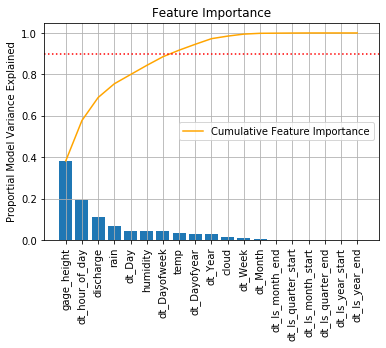

In [109]:
importances = model.feature_importances_
importances[::-1].sort()
indices = np.argsort(importances)[::-1]
cum_var = [importances[:x+1].sum() for x in range(len(importances))]
plt.figure(figsize = (6,4))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), df_feature_importances['Feature Name'], rotation=90)
plt.plot(cum_var, c = 'orange')
plt.ylabel('Proportial Model Variance Explained')
plt.axhline(0.9, c = 'red', linestyle = 'dotted')
plt.grid()
plt.legend(labels = ['Cumulative Feature Importance'], loc = 'center right')
plt.show()

The top 8 features capture >90% of the explained variability in the model. If the client desires a simpler model, the other models could easily be removed without losing too much predictive power.

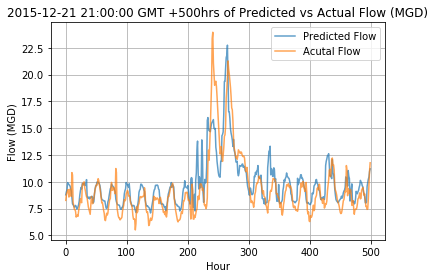

In [101]:
#Example predictions:
next_500_preds = model.predict(X_val[0:500])
next_500_actual = y_val[0:500]

plt.figure(figsize = (6,4))
for vals in [next_100_preds, next_100_actual]:
    plt.plot(range(len(vals)), vals, alpha = 0.7)
    
plt.legend(labels = ['Predicted Flow', 'Acutal Flow'])
plt.title(str(y_val.index[0])[:-6] + ' GMT +500hrs of Predicted vs Actual Flow (MGD)')
plt.xlabel('Hour')
plt.ylabel('Flow (MGD)')
plt.grid()
plt.show()

The model predicts the general rise/fall trends well but could do much better in terms of capturing the magnitude of valleys and peaks. The model could do much better in capturing the noise in the data.